In [1]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import requests

In [2]:
def draw_fig(eval_qubit, probability, counts, shots):
    counts = {key: value / shots for key, value in counts.items()}    
    p_tilde = [np.round(np.sin(i*np.pi/(2**eval_qubit))**2,3) for i in range(2**(eval_qubit-1)+1)]
    probs = np.zeros(2**eval_qubit, dtype=float)
    for state, value in counts.items():
        state_decimal = int(state, 2)
        probs[state_decimal] = value
        
    freqs =[]
    freqs.append(probs[0])
    i = 1
    while i < 2**eval_qubit/2:
        # print(f'These states correspond to the same bin: {i} and {2**m-i}')
        freqs.append(probs[i] + probs[2**eval_qubit-i])
        i += 1
    freqs.append(probs[2**(eval_qubit-1)])
    
    gridpoints = list(p_tilde)
    probabilities = list(freqs)
    
    fig = plt.figure()
    plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 15})
    
    plt.bar(gridpoints, probabilities, width=0.1 / len(probabilities), color='black')
    plt.axvline(probability, color="r", ls="--")
    plt.ylabel("Probability")
    plt.xlabel(r"$\tilde{p}$")
    plt.grid()
    return fig

# 내가 직접 저장한 Pickle file을 복원

In [3]:
with open('counts_set.pkl', 'rb') as f:
    loaded_counts_set = pickle.load(f)

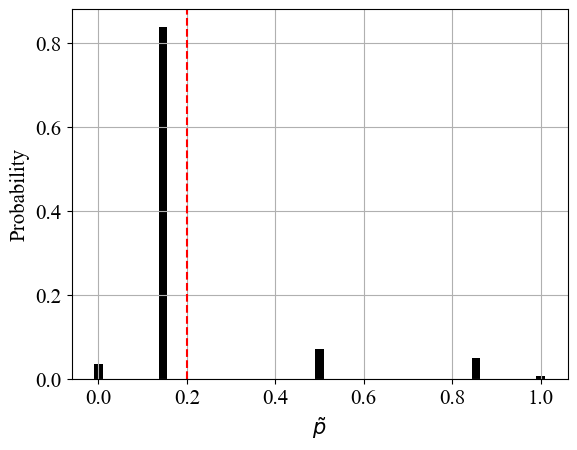

In [5]:
fig = draw_fig(eval_qubit=3, probability=0.2, 
               counts=loaded_counts_set['eval_3'], shots=8192)

# Job json 파일에서 Retrieve
https://cloud.ionq.com/jobs 에서 구할 수 있는 json

In [6]:
with open('qpu_keys.json', 'r') as keyfile:
    key = json.load(keyfile)['IonQ']

In [9]:
# 예시, 직접 다운받은 json 파일임
with open('31547fb8-8a0a-4d43-b26a-cad73dc59704.json', 'r') as f:
    loaded_data = json.load(f) 

In [10]:
url = f"https://api.ionq.co/v0.3/jobs/{loaded_data['id']}/results"
headers = {"Authorization": f"apiKey {key}"}

response = requests.get(url, headers=headers)

In [12]:
def make_binary(json_file):
    max_length = max(len(bin(int(key))) - 2 for key in json_file.json().keys())
    equal_length_binary_dict = {format(int(key), f'0{max_length}b'): value for key, value in json_file.json().items()}
    return equal_length_binary_dict

In [13]:
def sum_arbitrary_measurements(binary_json):
    summed_dict = {}
    
    for key1, value1 in binary_json.items():
        for key2, value2 in binary_json.items():
            if key1 != key2 and key1[1:] == key2[1:]:
                new_key = key1[1:]
                if new_key not in summed_dict:
                    summed_dict[new_key] = value1 + value2
    return summed_dict

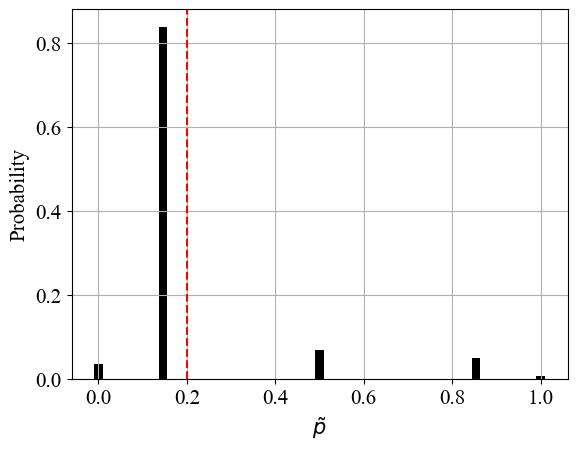

In [18]:
fig = draw_fig(eval_qubit=loaded_data['qubits']-1, 
               probability=0.2, 
               counts=sum_arbitrary_measurements(make_binary(response)), 
               shots=1)